In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from scipy.stats import skew
from scipy.stats import mode
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

In [13]:
train = pd.read_csv('carInsurance_train.csv')
test = pd.read_csv('carInsurance_test.csv')

In [14]:
print('The train dataset has %d observations and %d features' % (train.shape[0], train.shape[1]))
print('The test dataset has %d observations and %d features' % (test.shape[0], test.shape[1]))

The train dataset has 4000 observations and 19 features
The test dataset has 1000 observations and 19 features


In [15]:
train.describe()

,Id,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,0.401000
std,1154.844867,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,0.490162
min,1.000000,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,2000.500000,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,3000.250000,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,1.000000
max,4000.000000,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,1.000000


In [16]:
train.describe(include=['O'])

,Job,Marital,Education,Communication,LastContactMonth,Outcome,CallStart,CallEnd
count,3981,4000,3831,3098,4000,958,4000,4000
unique,11,3,3,2,12,3,3777,3764
top,management,married,secondary,cellular,may,failure,17:11:04,10:22:30
freq,893,2304,1988,2831,1049,437,3,3


In [17]:
train.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


C:\Users\HP\AppData\Local\Temp\ipykernel_1376\3637829707.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = train.corr()


<Axes: >

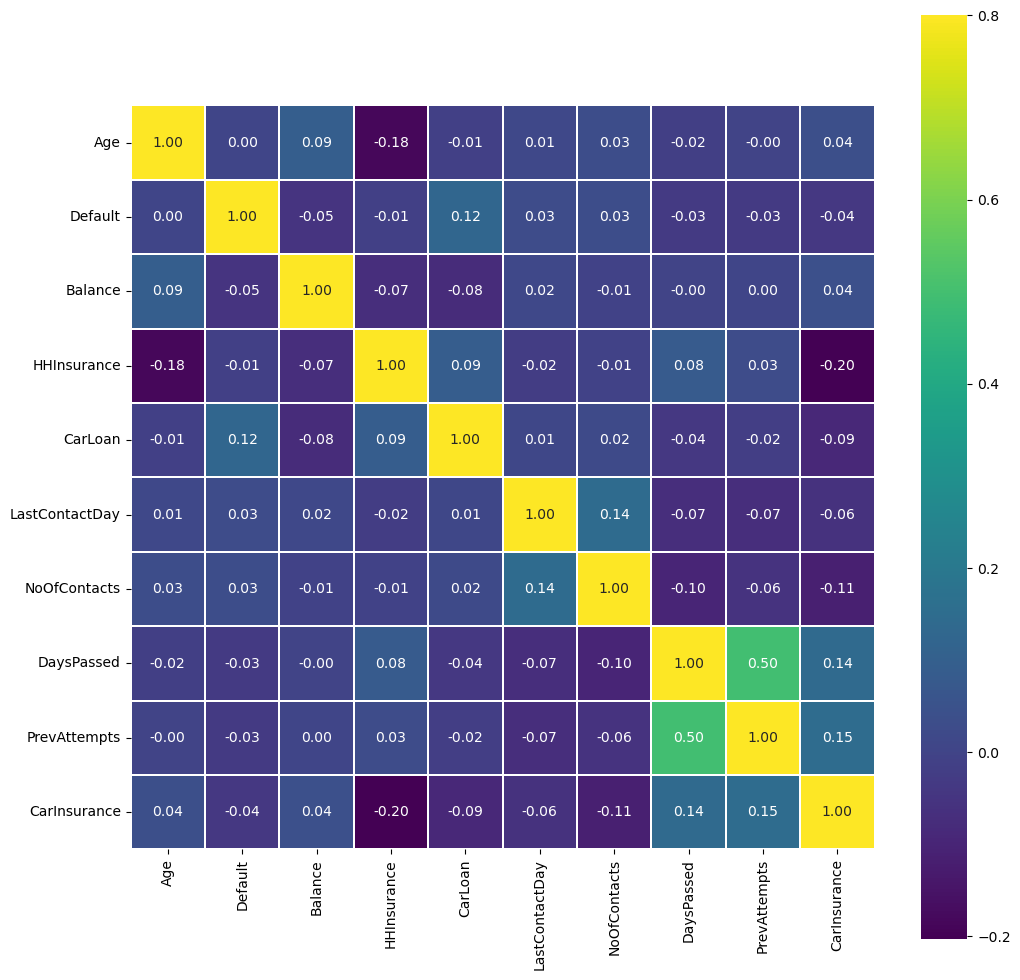

In [18]:
colormap = plt.cm.viridis
cor = train.corr()
cor = cor.drop(['Id'],axis=1).drop(['Id'],axis=0)
plt.figure(figsize=(12,12))
sns.heatmap(cor,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='white',linewidths=0.1)

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


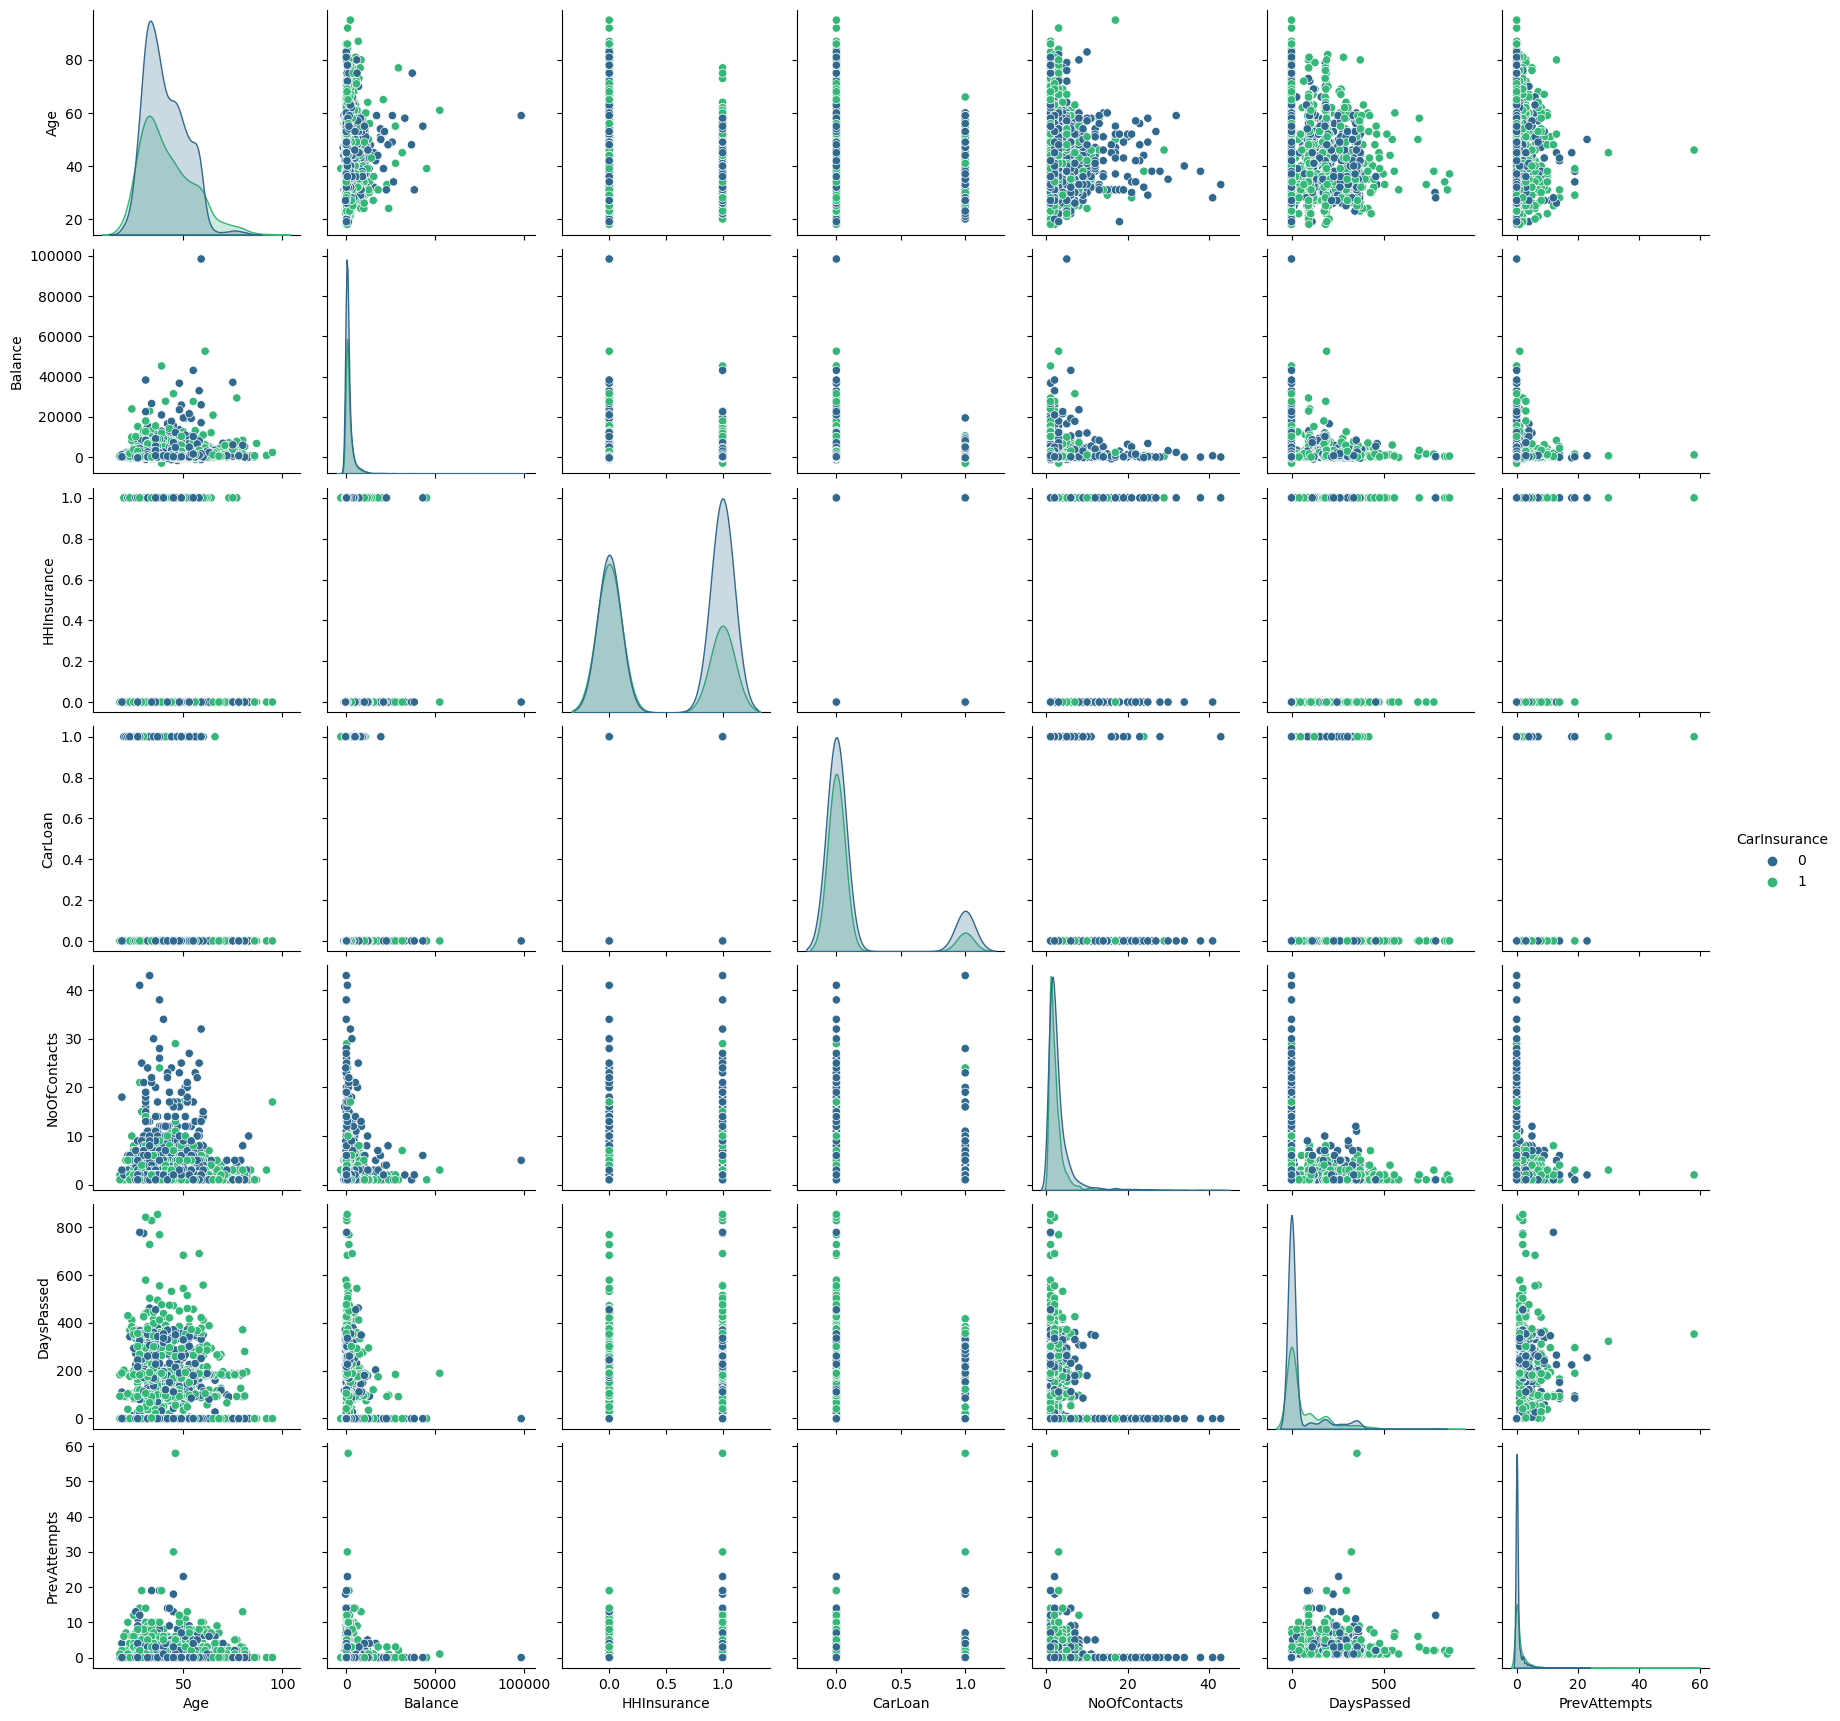

In [19]:
imp_feats = ['CarInsurance','Age','Balance','HHInsurance', 'CarLoan','NoOfContacts','DaysPassed','PrevAttempts']
sns.pairplot(train[imp_feats],hue='CarInsurance',palette='viridis',size=2.5)
plt.show()

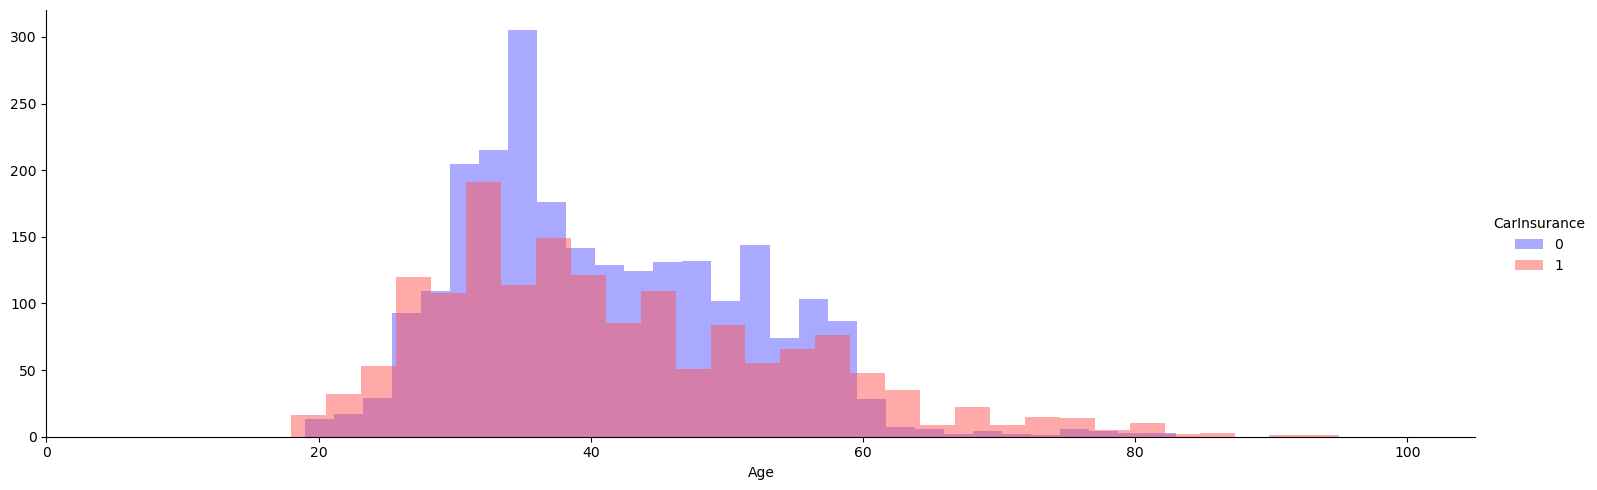

In [20]:
facet = sns.FacetGrid(train, hue='CarInsurance',height=5,aspect=3,palette='seismic')
facet.map(plt.hist,'Age',bins=30,alpha=0.5)
facet.set(xlim=(0,train.Age.max()+10))
facet.add_legend()

In [21]:
train[train['Balance']>80000]
train = train.drop(train[train.index==1742].index)

In [22]:
all=pd.concat([train,test],keys=('train','test'))
all.drop(['CarInsurance','Id'],axis=1,inplace=True)
print(all.shape)

(4999, 17)


In [23]:
total = all.isnull().sum()
pct = total/all.isnull().count()
NAs = pd.concat([total,pct],axis=1,keys=('Total','Pct'))
NAs[NAs.Total>0].sort_values(by='Total',ascending=False)

,Total,Pct
Outcome,3798,0.759752
Communication,1123,0.224645
Education,216,0.043209
Job,24,0.004801


In [24]:
all_df = all.copy()

# Fill missing outcome as not in previous campaign
all_df[all_df['DaysPassed']==-1].count()
all_df.loc[all_df['DaysPassed']==-1,'Outcome']='NoPrev'

# Fill missing communication with none 
all_df['Communication'].value_counts()
all_df['Communication'].fillna('None',inplace=True)

# Fill missing education with the most common education level by job type
all_df['Education'].value_counts()

# Create job-education level mode mapping
edu_mode=[]
job_types = all_df.Job.value_counts().index
for job in job_types:
    mode = all_df[all_df.Job==job]['Education'].value_counts().nlargest(1).index
    edu_mode = np.append(edu_mode,mode)
edu_map=pd.Series(edu_mode,index=all_df.Job.value_counts().index)

# Apply the mapping to missing eductaion obs
for j in job_types:
    all_df.loc[(all_df['Education'].isnull()) & (all_df['Job']==j),'Education'] = edu_map.loc[edu_map.index==j][0]
all_df['Education'].fillna('None',inplace=True)

# Fill missing job with none
all_df['Job'].fillna('None',inplace=True)

# Double check if there is still any missing value
all_df.isnull().sum().sum()

0

In [25]:

# Create age group based on age bands
all_df['AgeBand']=pd.cut(all_df['Age'],5)
print(all_df['AgeBand'].value_counts())

all_df.loc[(all_df['Age']>=17) & (all_df['Age']<34),'AgeBin'] = 1
all_df.loc[(all_df['Age']>=34) & (all_df['Age']<49),'AgeBin'] = 2
all_df.loc[(all_df['Age']>=49) & (all_df['Age']<65),'AgeBin'] = 3
all_df.loc[(all_df['Age']>=65) & (all_df['Age']<80),'AgeBin'] = 4
all_df.loc[(all_df['Age']>=80) & (all_df['Age']<96),'AgeBin'] = 5
all_df['AgeBin'] = all_df['AgeBin'].astype(int)

# Create balance groups
all_df['BalanceBand']=pd.cut(all_df['Balance'],5)
print(all_df['BalanceBand'].value_counts())
all_df.loc[(all_df['Balance']>=-3200) & (all_df['Balance']<17237),'BalanceBin'] = 1
all_df.loc[(all_df['Balance']>=17237) & (all_df['Balance']<37532),'BalanceBin'] = 2
all_df.loc[(all_df['Balance']>=37532) & (all_df['Balance']<57827),'BalanceBin'] = 3
all_df.loc[(all_df['Balance']>=57827) & (all_df['Balance']<78122),'BalanceBin'] = 4
all_df.loc[(all_df['Balance']>=78122) & (all_df['Balance']<98418),'BalanceBin'] = 5
all_df['BalanceBin'] = all_df['BalanceBin'].astype(int)

all_df = all_df.drop(['AgeBand','BalanceBand','Age','Balance'],axis=1)

# Convert education level to numeric 
all_df['Education'] = all_df['Education'].replace({'None':0,'primary':1,'secondary':2,'tertiary':3})

(33.4, 48.8]      2184
(17.923, 33.4]    1508
(48.8, 64.2]      1147
(64.2, 79.6]       133
(79.6, 95.0]        27
Name: AgeBand, dtype: int64
(-3113.645, 8071.0]    4847
(8071.0, 19200.0]       123
(19200.0, 30329.0]       20
(30329.0, 41458.0]        5
(41458.0, 52587.0]        4
Name: BalanceBand, dtype: int64


In [26]:
# Get call length
all_df['CallEnd'] = pd.to_datetime(all_df['CallEnd'])
all_df['CallStart'] = pd.to_datetime(all_df['CallStart'])
all_df['CallLength'] = ((all_df['CallEnd'] - all_df['CallStart'])/np.timedelta64(1,'m')).astype(float)
all_df['CallLenBand']=pd.cut(all_df['CallLength'],5)
print(all_df['CallLenBand'].value_counts())

# Create call length bins
all_df.loc[(all_df['CallLength']>= 0) & (all_df['CallLength']<11),'CallLengthBin'] = 1
all_df.loc[(all_df['CallLength']>=11) & (all_df['CallLength']<22),'CallLengthBin'] = 2
all_df.loc[(all_df['CallLength']>=22) & (all_df['CallLength']<33),'CallLengthBin'] = 3
all_df.loc[(all_df['CallLength']>=33) & (all_df['CallLength']<44),'CallLengthBin'] = 4
all_df.loc[(all_df['CallLength']>=44) & (all_df['CallLength']<55),'CallLengthBin'] = 5
all_df['CallLengthBin'] = all_df['CallLengthBin'].astype(int)
all_df = all_df.drop('CallLenBand',axis=1)

# Get call start hour
all_df['CallStartHour'] = all_df['CallStart'].dt.hour
print(all_df[['CallStart','CallEnd','CallLength','CallStartHour']].head())

# Get workday of last contact based on call day and month, assuming the year is 2016
all_df['LastContactDate'] = all_df.apply(lambda x:datetime.datetime.strptime("%s %s %s" %(2016,x['LastContactMonth'],x['LastContactDay']),"%Y %b %d"),axis=1)
all_df['LastContactWkd'] = all_df['LastContactDate'].dt.weekday
all_df['LastContactWkd'].value_counts()
all_df['LastContactMon'] = all_df['LastContactDate'].dt.month
all_df = all_df.drop('LastContactMonth',axis=1)

# Get week of last contact
all_df['LastContactWk'] = all_df['LastContactDate'].dt.week

# Get num of week in a month. There might be easier ways to do this, I will keep exploring. 
MonWk = all_df.groupby(['LastContactWk','LastContactMon'])['Education'].count().reset_index()
MonWk = MonWk.drop('Education',axis=1)
MonWk['LastContactWkNum']=0
for m in range(1,13):
    k=0
    for i,row in MonWk.iterrows():
        if row['LastContactMon']== m:
            k=k+1
            row['LastContactWkNum']=k
            
def get_num_of_week(df):
    for i,row in MonWk.iterrows():
        if (df['LastContactWk']== row['LastContactWk']) & (df['LastContactMon']== row['LastContactMon']):
            return row['LastContactWkNum']

all_df['LastContactWkNum'] = all_df.apply(lambda x: get_num_of_week(x),axis=1)
print(all_df[['LastContactWkNum','LastContactWk','LastContactMon']].head(10))

(0.0292, 10.91]     4274
(10.91, 21.737]      601
(21.737, 32.563]     104
(32.563, 43.39]       15
(43.39, 54.217]        5
Name: CallLenBand, dtype: int64
                  CallStart             CallEnd  CallLength  CallStartHour
train 0 2024-05-01 13:45:20 2024-05-01 13:46:30    1.166667             13
      1 2024-05-01 14:49:03 2024-05-01 14:52:08    3.083333             14
      2 2024-05-01 16:30:24 2024-05-01 16:36:04    5.666667             16
      3 2024-05-01 12:06:43 2024-05-01 12:20:22   13.650000             12
      4 2024-05-01 14:35:44 2024-05-01 14:38:56    3.200000             14


C:\Users\HP\AppData\Local\Temp\ipykernel_1376\3296382888.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  all_df['LastContactWk'] = all_df['LastContactDate'].dt.week


         LastContactWkNum  LastContactWk  LastContactMon
train 0                 4              4               1
      1                 4             21               5
      2                 1             22               6
      3                 2             19               5
      4                 1             22               6
      5                 3             20               5
      6                 3             11               3
      7                 2             19               5
      8                 3             46              11
      9                 2             19               5


In [27]:
cat_feats = all_df.select_dtypes(include=['object']).columns
num_feats = all_df.select_dtypes(include=['float64','int64']).columns
num_df = all_df[num_feats]
cat_df = all_df[cat_feats]
print('There are %d numeric features and %d categorical features\n' %(len(num_feats),len(cat_feats)))
print('Numeric features:\n',num_feats.values)
print('Categorical features:\n',cat_feats.values)

There are 14 numeric features and 4 categorical features

Numeric features:
 ['Education' 'Default' 'HHInsurance' 'CarLoan' 'LastContactDay'
 'NoOfContacts' 'DaysPassed' 'PrevAttempts' 'CallLength' 'CallStartHour'
 'LastContactWkd' 'LastContactMon' 'LastContactWk' 'LastContactWkNum']
Categorical features:
 ['Job' 'Marital' 'Communication' 'Outcome']


In [28]:
# One hot encoding
cat_df = pd.get_dummies(cat_df)

In [29]:
# Merge all features
all_data = pd.concat([num_df,cat_df],axis=1)

In [30]:
idx=pd.IndexSlice
train_df=all_data.loc[idx[['train',],:]]
test_df=all_data.loc[idx[['test',],:]]
train_label=train['CarInsurance']
print(train_df.shape)
print(len(train_label))
print(test_df.shape)

(3999, 36)
3999
(1000, 36)


In [31]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(train_df,train_label,test_size = 0.3,random_state=3)

In [32]:
def get_best_model(estimator, params_grid={}):
    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(x_train,y_train)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [33]:
def model_fit(model,feature_imp=True,cv=5):

    # model fit   
    clf = model.fit(x_train,y_train)
    
    # model prediction     
    y_pred = clf.predict(x_test)
    
    # model report     
    cm = confusion_matrix(y_test,y_pred)
    plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

    print('\n--- Train Set -----------------------------')
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv)),np.std(cross_val_score(clf,x_train,y_train,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc'))))
    print('\n--- Validation Set -----------------------------')    
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv)),np.std(cross_val_score(clf,x_test,y_test,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc'))))
    print('-----------------------------------------------') 

    # feature importance 
    if feature_imp:
        feat_imp = pd.Series(clf.feature_importances_,index=all_data.columns)
        feat_imp = feat_imp.nlargest(15).sort_values()
        plt.figure()
        feat_imp.plot(kind="barh",figsize=(6,8),title="Most Important Features")

In [34]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Success','Failure']

# KNN Classifier


--- Best Parameters -----------------------------
{'n_neighbors': 6, 'p': 2, 'weights': 'distance'}

--- Best Model -----------------------------
KNeighborsClassifier(n_neighbors=6, weights='distance')

--- Train Set -----------------------------
Accuracy: 0.81888 +/- 0.0261
AUC: 0.88610 +/- 0.0178

--- Validation Set -----------------------------
Accuracy: 0.76333 +/- 0.0238
AUC: 0.83877 +/- 0.0118
-----------------------------------------------


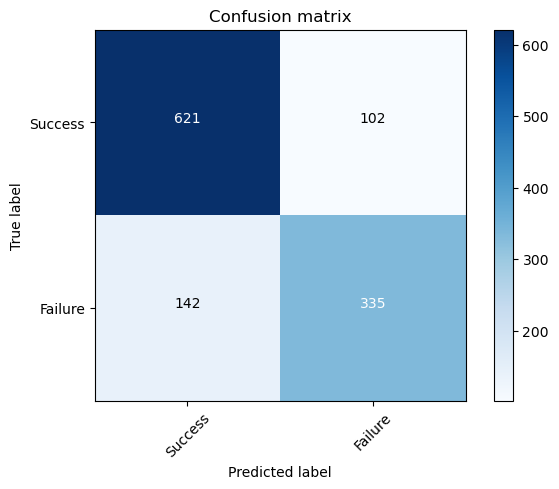

In [35]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[5,6,7], 
              'p':[1,2],
              'weights':['uniform','distance']}
clf_knn = get_best_model(knn,parameters)
model_fit(model=clf_knn, feature_imp=False)


# Naive Bayes Classifier


--- Train Set -----------------------------
Accuracy: 0.72026 +/- 0.0126
AUC: 0.78441 +/- 0.0122

--- Validation Set -----------------------------
Accuracy: 0.71083 +/- 0.0195
AUC: 0.77291 +/- 0.0287
-----------------------------------------------


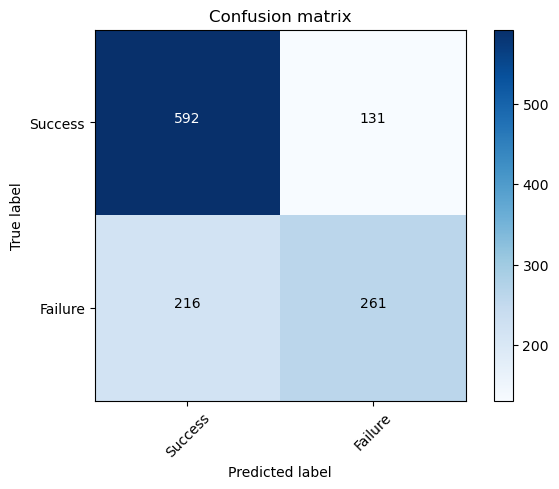

In [36]:
#Naive Bayes Classifier
# As expected, Naive Bayes classifier doesn't perform well here. 
# There are multiple reasons. Some of the numeric features are not normally distributed, which is a strong assemption hold by Naive Bayes. 
# Also, features are definitely not independent.  
clf_nb = GaussianNB()
model_fit(model=clf_nb,feature_imp=False)

# Logistic Regression

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", li


--- Best Parameters -----------------------------
{'C': 0.9, 'penalty': 'l2'}

--- Best Model -----------------------------
LogisticRegression(C=0.9, random_state=3)

--- Train Set -----------------------------


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.81137 +/- 0.0186


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

AUC: 0.89185 +/- 0.0164

--- Validation Set -----------------------------


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.79750 +/- 0.0164


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

AUC: 0.88721 +/- 0.0099
-----------------------------------------------


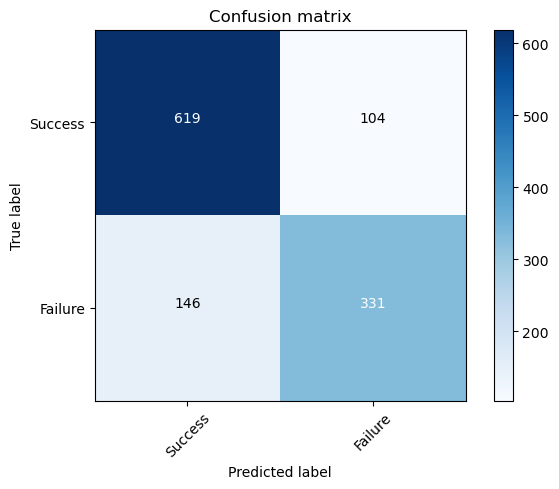

In [37]:
# We're making progress here. Logistic regression performs better than KNN. 
lg = LogisticRegression(random_state=3)
parameters = {'C':[0.8,0.9,1], 
              'penalty':['l1','l2']}
clf_lg = get_best_model(lg,parameters)
model_fit(model=clf_lg, feature_imp=False)

# Random Forest Classifier


--- Best Parameters -----------------------------
{'max_depth': 10, 'max_features': 13, 'min_samples_split': 11, 'n_estimators': 100}

--- Best Model -----------------------------
RandomForestClassifier(max_depth=10, max_features=13, min_samples_split=11,
                       random_state=3)

--- Train Set -----------------------------
Accuracy: 0.84888 +/- 0.0085
AUC: 0.92495 +/- 0.0084

--- Validation Set -----------------------------
Accuracy: 0.81750 +/- 0.0174
AUC: 0.90742 +/- 0.0082
-----------------------------------------------


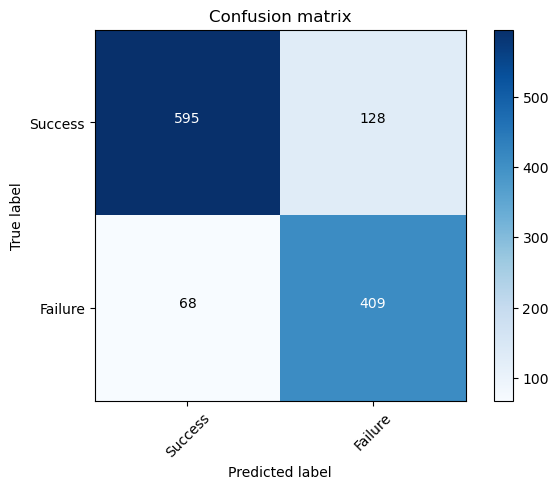

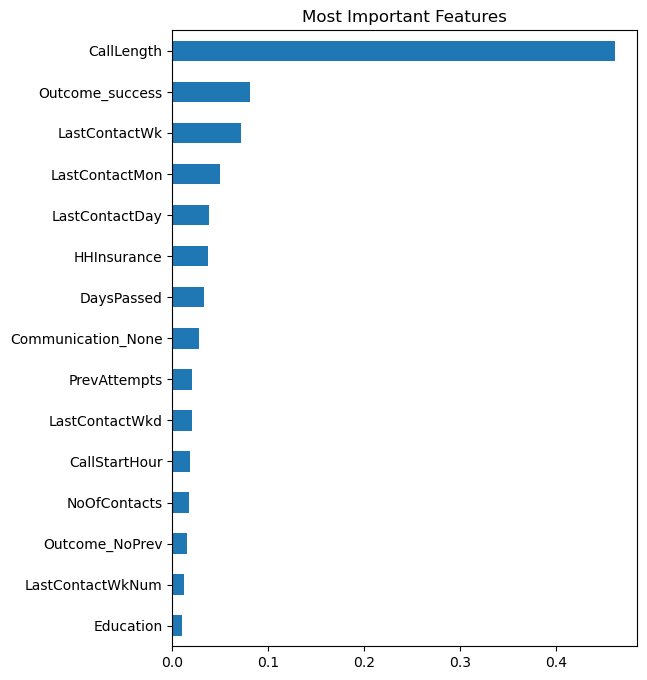

In [39]:
# I did some manual parameter tuning here. This is the best model so far. 
# Based on the feature importance report, call length, last contact week, and previous success are strong predictors of cold call success
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
            'max_depth':[10],
            'max_features':[13,14],
            'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)
model_fit(model=clf_rf, feature_imp=True)

# Support Vector Machine


--- Best Parameters -----------------------------
{'C': 1, 'gamma': 0.01}

--- Best Model -----------------------------
SVC(C=1, gamma=0.01, probability=True, random_state=3)

--- Train Set -----------------------------
Accuracy: 0.83603 +/- 0.0216
AUC: 0.90429 +/- 0.0156

--- Validation Set -----------------------------
Accuracy: 0.77833 +/- 0.0236
AUC: 0.85991 +/- 0.0139
-----------------------------------------------


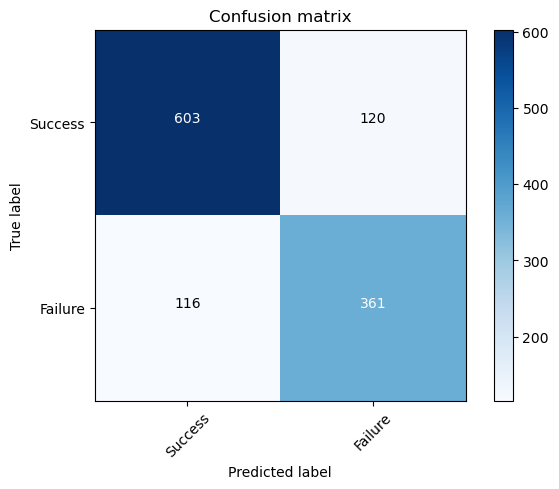

In [40]:
# try a SVM RBF model 
svc = svm.SVC(kernel='rbf', probability=True, random_state=3)
parameters = {'gamma': [0.005,0.01,0.02],
              'C': [0.5,1,5]}
clf_svc = get_best_model(svc, parameters)
model_fit(model=clf_svc,feature_imp=False)

# Xg boost


--- Best Parameters -----------------------------
{'colsample_bytree': 0.4, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 900, 'subsample': 0.8}

--- Best Model -----------------------------
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=900, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

--- Train Set -----------

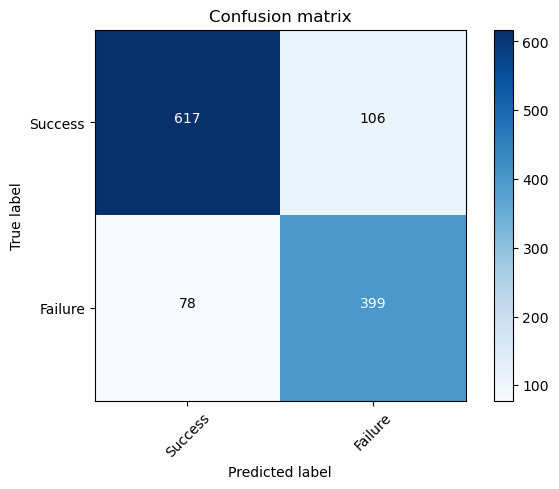

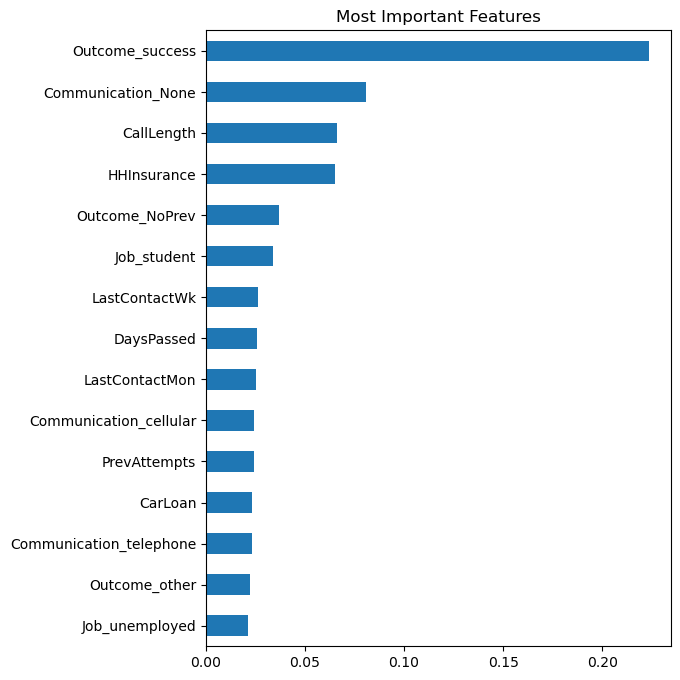

In [41]:
import xgboost as xgb
xgb = xgb.XGBClassifier()
parameters={'n_estimators':[900,1000,1100],
            'learning_rate':[0.01],
            'max_depth':[8],
            'min_child_weight':[1],
            'subsample':[0.8],
            'colsample_bytree':[0.3,0.4,0.5]}
clf_xgb= get_best_model(xgb,parameters)
model_fit(model=clf_xgb, feature_imp=True)

In [52]:
# Compare model performance
clfs= [clf_knn, clf_nb, clf_lg, clf_rf, clf_svc, clf_xgb]
index =['K-Nearest Neighbors','Naive Bayes','Logistic Regression','Random Forest','Support Vector Machines','XGBoost']
scores=[]
for clf in clfs:
    score = np.mean(cross_val_score(clf,x_test,y_test,cv=5,scoring = 'accuracy'))
    scores = np.append(scores,score)
models = pd.Series(scores,index=index)
models.sort_values(ascending=False)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

XGBoost                    0.830000
Random Forest              0.817500
Logistic Regression        0.797500
Support Vector Machines    0.778333
K-Nearest Neighbors        0.763333
Naive Bayes                0.710833
dtype: float64